# CryoCloud Tutorials: SlideRule

Tutorial Leads: [Scott Henderson](mailto:scottyh@uw.edu) and [Tyler Sutterley](mailto:tsutterl@uw.edu)

```{admonition}Learning Objectives
- How to use Sliderule software for scalable ICESat-2 data access & on-demand processing
- Integrating ICESat-2 data with other datasets (such as raster DEMs)
- Visualizing ICESat-2 elevations with interactive maps and matplotlib figures
```

### SlideRule Introduction

SlideRule is a collaborative effort between NASA Goddard Space Flight Center (GSFC) and the University of Washington. It is an on-demand science data processing service that runs on Amazon Web Services (AWS) and responds to REST API calls to process and return science results.  This _science data as a service_ model is a new way for researchers to work and analyze data. SlideRule was designed to enable researchers to have low-latency access to custom-generated, high-level data products.

SlideRule users provide specific parameters at the time of the request to compute products that fit their science needs. SlideRule then uses cloud-optimized versions of computational algorithms and dynamic scaling of the cluster to process data efficiently. All data is then returned to the user as a `geopandas` `GeoDataFrame`.

SlideRule has access to ICESat-2, GEDI, Landsat, ArcticDEM, REMA, and other datasets stored in s3. The SlideRule Python client is organized into the following submodules, each with a specific functionality:

* `sliderule`: the core module
* `earthdata` :functions that access CMR (NASA's Common Metadata Repository), CMR-STAC, and TNM (The National Map, for the 3DEP data hosted by USGS)
* `h5`: APIs for directly reading HDF5 and NetCDF4 data using `h5coro`
* `raster`: APIs for sampling supported raster datasets
* `icesat2`: APIs for processing ICESat-2 data
* `gedi`: APIs for processing GEDI data
* `io`: functions for reading and writing local files with SlideRule results
* `ipysliderule`: functions for building interactive Jupyter notebooks that interface to SlideRule

[Documentation for using SlideRule](https://slideruleearth.io/web/rtd/) is available from the [project website](https://slideruleearth.io/web/) 


```{admonition}Quick links
* Website: https://slideruleearth.io
* Documentation: https://slideruleearth.io/web/rtd
* Web Demo: https://demo.slideruleearth.io
* GitHub Repository: https://github.com/ICESat2-SlideRule/sliderule
* Python Examples GitHub Repository: https://github.com/ICESat2-SlideRule/sliderule-python
```


#### **Q: What is ICESat-2?**
ICESat-2 is a spaceborne _laser altimeter_ that measures the surface topography of the Earth. ICESat-2 emits six 532nm laser beams which reflect off the Earth's surface approximately every 70cm _along-track_. 

#### **Q: Where is ICESat-2 Data Located**
All ICESat-2 data is hosted by the NASA Snow and Ice Distributed Active Archive Centers (DAAC) at the National Snow and Ice Data Center (NSIDC). Most of the ICESat-2 data is additionally hosted on AWS s3 buckets in `us-west-2`, which are accessible through NASA Earthdata cloud.

#### **Q: What does the SlideRule ICESat-2 API actually do?**
Along with data access and subsetting, SlideRule can create a simplified version of the [ICESat-2 land ice height (ATL06)](https://nsidc.org/data/atl06) product that can be adjusted to suit different needs. SlideRule processes the [ICESat-2 geolocated photon height (ATL03)](https://nsidc.org/data/atl03) data products into _along-track_ segments of surface elevation. SlideRule let's you create customized ICESat-2 segment heights _directly_ from the photon height data anywhere on the globe, _on-demand_ and quickly.


In [1]:
# This notebook requires Sliderule>=4.1
%pip install --quiet "sliderule>=4.1"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import logging, warnings
import geopandas as gpd
import sliderule.h5
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import shapely.geometry
import owslib.wms

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Start by initiating SlideRule
- Sets the URL for accessing the SlideRule service
- Builds a table of servers available for processing data

In [4]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("slideruleearth.io", loglevel=logging.WARNING)
# turn off warnings for tutorial
warnings.filterwarnings('ignore')

#### Set options for making science data processing requests to SlideRule

We'll start with a basic example where we can vary the length of each segment for a SlideRule ICESat-2 `atl06` request. We will get the average height of the surface by fitting a sloping segment to photons _along-track_. We will use all photons that lie within a _window_ of the fit surface. This process can capture the effects of small-scale surface topography when appropriate segment length scales are chosen. 

<table>
  <tbody>
    <tr>
      <th align='center' max-width="30%">Parameter</th>
      <th align='left' max-width="70%">Definition</th>
    </tr>
    <tr>
      <td align='left' valign='top' width="30%">
        Surface Type
       </td>
      <td align='left' valign='top' width="70%">
        Sets the parameters for ATL03 photon confidence classification
        <ol style="line-height: 1.5em">
            <li>land</li>
            <li>ocean</li>
            <li>sea ice</li>
            <li>land ice</li>
            <li>inland water</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="30%">
        Length
       </td>
      <td align='left' valign='top' width="70%">
        How long each segment should be in meters
       </td>
    </tr>
  </tbody>
</table>

In [5]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
SRwidgets.set_atl06_defaults()
SRwidgets.VBox(SRwidgets.atl06(display='basic'))

#### Select regions of interest for submitting to SlideRule

Create polygons or bounding boxes for our regions of interest. This map is also our viewer for inspecting our SlideRule ICESat-2 data returns.

Interactive maps within the SlideRule python API are build upon [ipyleaflet](https://ipyleaflet.readthedocs.io), which are Jupyter and python bindings for the fantastic [Leaflet](https://leafletjs.com/) javascript library.

In [6]:
# create ipyleaflet map in specified projection
m1 = sliderule.ipysliderule.leaflet('Global', zoom=10,
    full_screen_control=True)
# read and add region of interest
reg = gpd.read_file('grandmesa.geojson')
m1.add_region(sliderule.io.from_geodataframe(reg))
m1.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

#### Build and transmit requests to SlideRule

- SlideRule will query the [NASA Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/) for ATL03 data within our region of interest
- When using the `icesat2` asset, the ICESat-2 ATL03 data are then accessed from the NSIDC AWS s3 bucket in `us-west-2`
- The ATL03 granules is spatially subset within SlideRule to our exact region of interest
- SlideRule then uses our specified parameters to calculate average height segments from the ATL03 data in parallel
- The completed data is streamed concurrently back and combined into a `geopandas` `GeoDataFrame` within the Python client

In [7]:
%%time
# build sliderule parameters using latest values from widget
parms = SRwidgets.build_atl06()

# clear existing geodataframe results
elevations = [sliderule.emptyframe()]

# for each region of interest
for poly in m1.regions:
    # add polygon from map to sliderule parameters
    parms["poly"] = poly
    # make the request to the SlideRule (ATL06-SR) endpoint
    # and pass it the request parameters to request ATL06 Data
    elevations.append(sliderule.icesat2.atl06p(parms))
# concatenate the results into a single geodataframe
gdf1 = gpd.pd.concat(elevations)

CPU times: user 7.76 s, sys: 251 ms, total: 8.01 s
Wall time: 2min 56s


#### Review GeoDataFrame output
Here, we will inspect the columns, number of returns and returns at the top of the GeoDataFrame using `head()`. 

See the [SlideRule ICESat-2 Elevations documentation](https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html#elevations-atl06) for more descriptions of each column.

In [8]:
print(f'Returned {gdf1.shape[0]} records')
gdf1.head()

Returned 297393 records


,geometry,h_mean,segment_id,spot,x_atc,rgt,y_atc,dh_fit_dx,pflags,w_surface_window_final,h_sigma,rms_misfit,cycle,gt,n_fit_photons
2018-12-13 08:01:25.641970944,POINT (-108.08709 39.14534),2056.711710,784635.0,2.0,15715688.0,1156.0,-2381.687988,0.269039,0.0,9.998273,0.461017,1.814868,1.0,50.0,16.0
2018-12-13 08:01:25.644785920,POINT (-108.08712 39.14516),2060.451774,784636.0,2.0,15715708.0,1156.0,-2381.638672,0.190734,2.0,5.752973,0.000000,0.000000,1.0,50.0,10.0
2018-12-13 08:01:25.650857728,POINT (-108.01334 39.14127),2212.098551,784627.0,6.0,15715528.0,1156.0,4008.179199,0.131911,0.0,3.418886,0.145620,0.617595,1.0,10.0,39.0
2018-12-13 08:01:25.653670656,POINT (-108.01337 39.14109),2214.409829,784628.0,6.0,15715548.0,1156.0,4008.182861,0.084734,0.0,3.000000,0.055851,0.460987,1.0,10.0,74.0
2018-12-13 08:01:25.656484608,POINT (-108.01339 39.14091),2216.056906,784629.0,6.0,15715568.0,1156.0,4008.188232,0.083600,0.0,3.000000,0.041939,0.390870,1.0,10.0,87.0


#### Add GeoDataFrame to map

Choose a variable for visualization on the interactive leaflet map. The data can be plotted in any available [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html). SlideRule as a default limits the number of points in the plot to ensure the stability of the leaflet map.

Here, we're going to visualize the surface elevation field `h_mean`. This is the average elevation of the ICESat-2 geolocated photons that are located within a vertical window (`w_surface_window_final`) around the surface.

You can _hover_ over individual data points to display a _tooltip_ containing the data values at that location.


In [9]:
SRwidgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [10]:
# ATL06-SR fields for hover tooltip
fields = m1.default_atl06_fields()
gdf1.leaflet.GeoData(m1.map, column_name=SRwidgets.column_name, cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True, fields=fields)
# install handlers and callbacks
gdf1.leaflet.add_selected_callback(SRwidgets.atl06_click_handler)
m1.add_region_callback(gdf1.leaflet.handle_region)

#### Create plots for a single track
SlideRule ICESat-2 transect plot types:
- `cycles`: Will plot all available cycles of data returned by SlideRule for a single RGT and ground track
- `scatter`: Will plot data returned by SlideRule for a single RGT, ground track and cycle

Note: the cycles plots should only be used in regions with [repeat Reference Ground Track (RGT) pointing](https://icesat-2.gsfc.nasa.gov/science/specs).

In [11]:
# set defaults for along-track plot
SRwidgets.rgt.value = '737'
SRwidgets.ground_track.value = 'gt3r'
SRwidgets.cycle.value = '20'

To select an alternative track to plot, you can _click_ on one of the data points in the leaflet map. This will auto-populate the RGT, Ground Track, and Cycle fields below.


In [12]:
# along-track plot parameters
SRwidgets.VBox([
    SRwidgets.plot_kind,
    SRwidgets.rgt,
    SRwidgets.ground_track,
    SRwidgets.cycle,
])

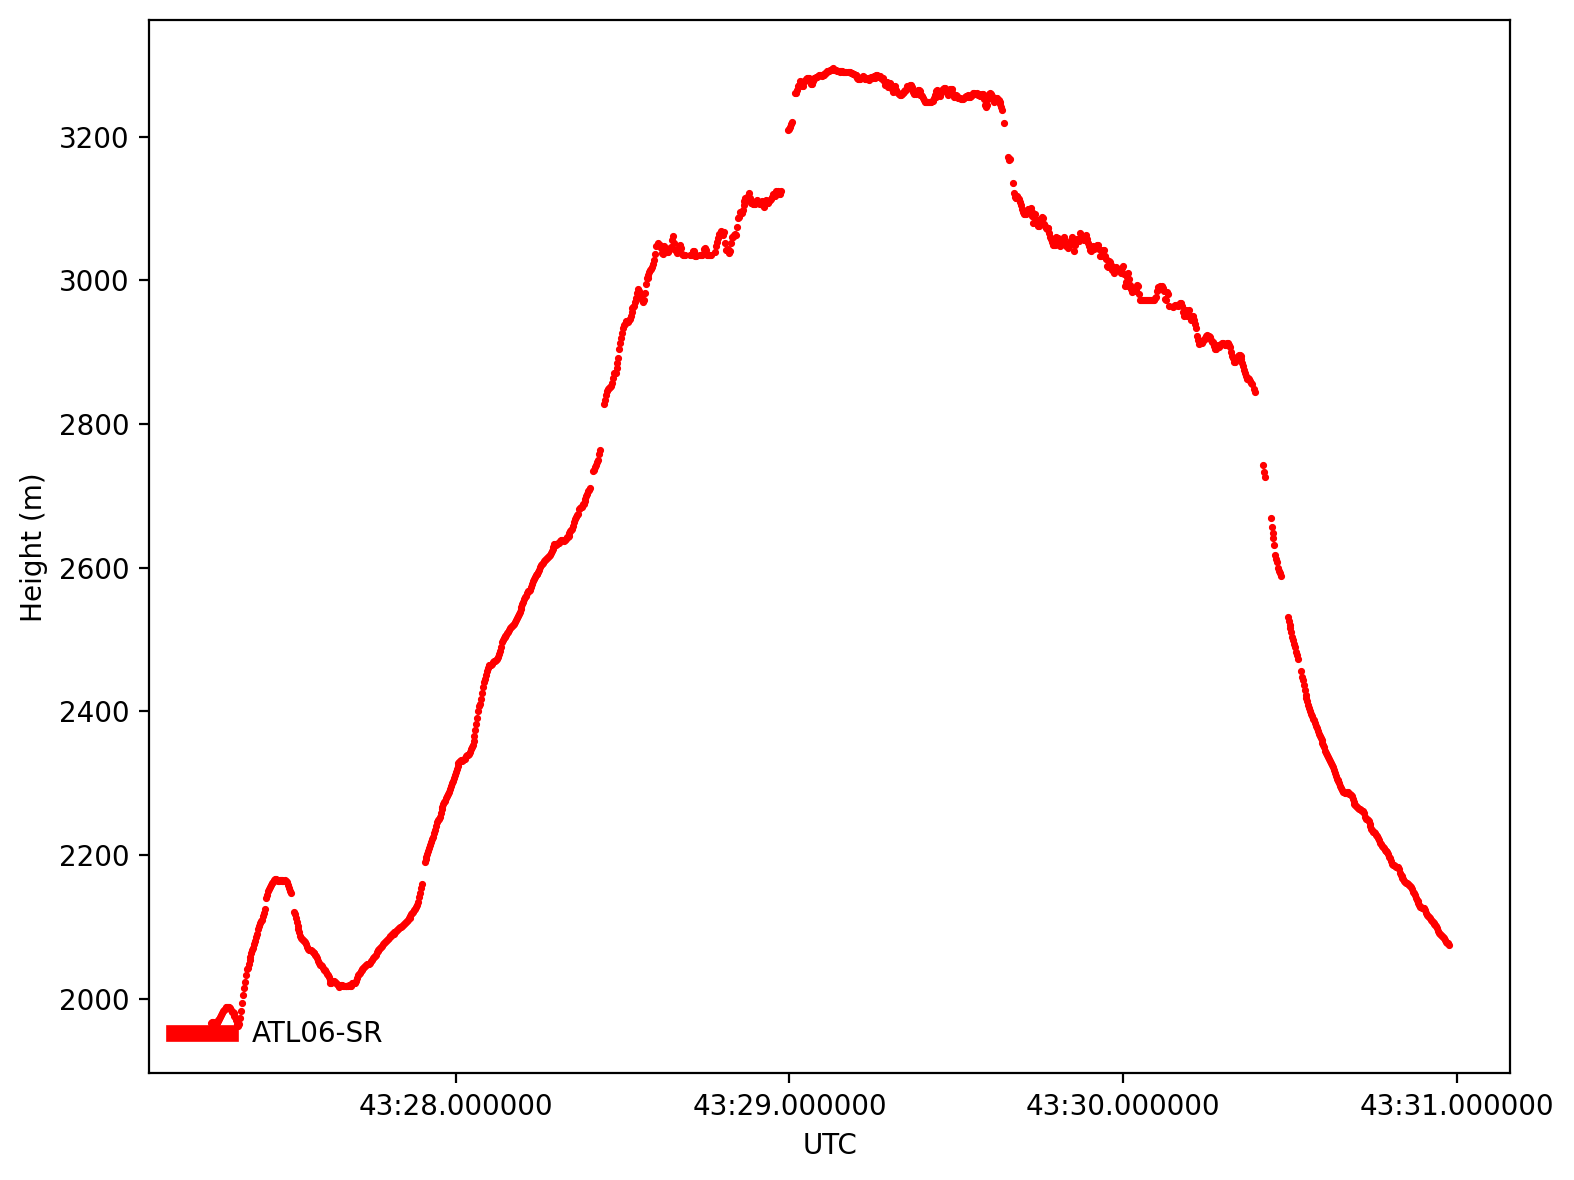

In [13]:
# default is to skip cycles with significant off-pointing
gdf1.icesat2.plot(kind=SRwidgets.plot_kind.value, cycle_start=3,
    legend=True, legend_frameon=False, **SRwidgets.plot_kwargs)

```{tip}
Can you identify the plateau at Grand Mesa?
```

### Advanced ICESat-2 SlideRule Example: Polar Altimetry and Raster Sampling

SlideRule also can use different sources for photon classification before calculating the average segment height.  
This is useful for example, in cases where there may be a vegetated canopy affecting the spread of the photon returns.
- ATL03 photon confidence values, based on algorithm-specific classification types for land, ocean, sea-ice, land-ice, or inland water
- [ATL08 Land and Vegetation Height product](https://nsidc.org/data/atl08) photon classification
- Experimental [YAPC (Yet Another Photon Classification)](https://github.com/tsutterley/yapc) photon-density-based classification

For this example, we will also use SlideRule to sample a digital elevation model (DEM) at the locations of our ICESat-2 elevations. For a detailed discussion of the raster sampling capability see the [GeoRaster page](https://slideruleearth.io/web/rtd/user_guide/GeoRaster.html) and the [sampling parameters](https://slideruleearth.io/web/rtd/user_guide/SlideRule.html#raster-sampling) in the SlideRule documentation.

```attention
SlideRule does not currently include first-photon bias or transmit-pulse shape bias corrections in the fit heights.
```

#### Leaflet Basemaps and Layers

There are 3 projections available within SlideRule for mapping ([Global](https://epsg.io/3857), [North](https://epsg.io/5936) and [South](https://epsg.io/3031)).  There are also contextual layers available for each projection. Most [xyzservice providers](https://xyzservices.readthedocs.io/en/stable/introduction.html) can be added as contextual layers to the global Web Mercator maps.

<table>
  <tbody>
    <tr>
      <th align='center' max-width="30%"><a href="https://epsg.io/3857">Global (Web Mercator, EPSG:3857)</a></th>
      <th align='center' max-width="30%"><a href="https://epsg.io/5936">North (Alaska Polar Stereographic, EPSG:5936)</a></th>
      <th align='center' max-width="30%"><a href="https://epsg.io/3031">South (Antarctic Polar Stereographic, EPSG:3031)</a></th>
    </tr>
    <tr>
      <td align='left' valign='top' width="30%">
        <ul style="line-height: 1.5em">
            <li><a href="https://apps.nationalmap.gov/3depdem/">USGS 3DEP Hillshade</a></li>
            <li><a href="https://asterweb.jpl.nasa.gov/gdem.asp">ASTER GDEM Hillshade</a></li>
            <li><a href="https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9">ESRI Imagery</a></li>
            <li><a href="http://glims.colorado.edu/glacierdata/">Global Land Ice Measurements from Space (GLIMS)</a></li>
            <li><a href="https://www.glims.org/RGI/">Randolph Glacier Inventory (RGI)</a></li>
        </ul>
       </td>
       <td align='left' valign='top' width="30%">
        <ul style="line-height: 1.5em">
            <li><a href="http://goto.arcgisonline.com/maps/Arctic_Imagery">ESRI Imagery</a></li>
            <li><a href="https://www.pgc.umn.edu/data/arcticdem">ArcticDEM</a></li>
        </ul>
       </td>
       <td align='left' valign='top' width="30%">
        <ul style="line-height: 1.5em">
            <li><a href="https://lima.usgs.gov/">Landsat Image Mosaic of Antarctica (LIMA)</a></li>
            <li><a href="https://nsidc.org/data/nsidc-0280">MODIS Mosaic of Antarctica (MOA)</a></li>
            <li><a href="https://nsidc.org/data/NSIDC-0103">Radarsat Antarctic Mapping Project (RAMP)</a></li>
            <li><a href="https://www.pgc.umn.edu/data/rema">Reference Elevation Model of Antarctica (REMA)</a></li>
        </ul>
      </td>
    </tr>
  </tbody>
</table>

Here, we will use the visualize data at Fenris Glacier in Greenland using the Northern Hemisphere polar stereographic projection.



In [14]:
# create ipyleaflet map in specified projection
m2 = sliderule.ipysliderule.leaflet('North',
    center=(66.55, -36.75), zoom=8)
# add ArcticDEM Hillshade layer
m2.add_layer(
    layers='ArcticDEM',
    rendering_rule={'rasterFunction': 'Hillshade Gray'}
)
# read and add region of interest
reg = gpd.read_file('Fenris_Gletscher_PS_v1.4.2.geojson')
m2.add_region(sliderule.io.from_geodataframe(reg))
m2.map

Map(center=[66.55, -36.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

#### Update options for making science data processing requests to SlideRule

Here we'll be able to adjust all the potential parameters for making a SlideRule ICESat-2 `atl06` request.

<table>
  <tbody>
    <tr>
      <th align='center' max-width="25%">Parameter</th>
      <th align='left' max-width="75%">Definition</th>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Classification
       </td>
      <td align='left' valign='top' width="75%">
        Photon classification types to use in signal selection
        <ul style="line-height: 1.5em">
            <li>atl03: signal confidence</li>
            <li>quality: signal quality flag</li>
            <li>atl08: classification from the land and vegetation algorithm</li>
            <li>yapc: confidence determined using a clustering algorithm</li>
        </ul>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Surface Type
       </td>
      <td align='left' valign='top' width="75%">
        Sets the parameters for ATL03 photon confidence classification
        <ol style="line-height: 1.5em">
            <li>land</li>
            <li>ocean</li>
            <li>sea ice</li>
            <li>land ice</li>
            <li>inland water</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Confidence
       </td>
      <td align='left' valign='top' width="75%">
        Numerical assessment of the signal likelihood of each photon
        <ol start="0" style="line-height: 1.5em">
            <li>photon is background</li>
            <li>photon is background within buffer of known surface</li>
            <li>low confidence of photon being signal</li>
            <li>medium confidence of photon being signal</li>
            <li>high confidence of photon being signal</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Quality
       </td>
      <td align='left' valign='top' width="75%">
        ATL03 instrumental photon quality 
        <ol start="0" style="line-height: 1.5em">
            <li>photon is nominal</li>
            <li>photon is possible afterpulse</li>
            <li>photon is possible impulse response</li>
            <li>photon is possible transmit echo path (TEP)</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Land class
       </td>
      <td align='left' valign='top' width="75%">
        ATL08 land and vegetation classification
        <ol start="0" style="line-height: 1.5em">
            <li>photon is noise or background</li>
            <li>photon is ground</li>
            <li>photon is canopy</li>
            <li>photon is top of canopy</li>
            <li>photon is not classified</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        YAPC kNN
       </td>
      <td align='left' valign='top' width="75%">
        Number of nearest neighbors to use in classification algorithm
        <ol start="0" style="line-height: 1.5em">
            <li>Automatic selection</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        YAPC h window
       </td>
      <td align='left' valign='top' width="75%">
        Window height for filtering neighbors in classification algorithm
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        YAPC x window
       </td>
      <td align='left' valign='top' width="75%">
        Window width for filtering neighbors in classification algorithm
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        YAPC minimum PE
       </td>
      <td align='left' valign='top' width="75%">
        Minimum number of photon events needed to create a YAPC score in classification algorithm
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        YAPC score
       </td>
      <td align='left' valign='top' width="75%">
        Minimum YAPC score for photons to be valid
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Length
       </td>
      <td align='left' valign='top' width="75%">
        How long each segment should be in meters
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Step
       </td>
      <td align='left' valign='top' width="75%">
        Distance between successive segments in meters
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PE Count
       </td>
      <td align='left' valign='top' width="75%">
        Minimum number of photon events needed within a segment to be valid
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Window
       </td>
      <td align='left' valign='top' width="75%">
        Minimum height of the final surface window used for selecting photons
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Sigma
       </td>
      <td align='left' valign='top' width="75%">
        Maximum allowed dispersion around the median height in meters
       </td>
    </tr>
  </tbody>
</table>

In [15]:
# display widgets for setting SlideRule parameters
SRwidgets.set_atl06_defaults()
SRwidgets.classification.value = ['atl03']
SRwidgets.surface_type.value = 'Land ice'
SRwidgets.VBox(SRwidgets.atl06())

In [16]:
%%time
# build sliderule parameters using latest values from widget
parms = SRwidgets.build_atl06()
# reduce data to a single cycle
parms["cycle"] = 19
# additionally sample ArcticDEM mosaic at ATL06-SR points
parms["samples"] = dict(mosaic= {
    "asset": "arcticdem-mosaic",
    "radius": 10.0,
    "zonal_stats": True
})

# clear existing geodataframe results
elevations = [sliderule.emptyframe()]

# for each region of interest
for poly in m2.regions:
    # add polygon from map to sliderule parameters
    parms["poly"] = poly
    # make the request to the SlideRule (ATL06-SR) endpoint
    # and pass it the request parameters to request ATL06 Data
    elevations.append(sliderule.icesat2.atl06p(parms))
# concatenate the results into a single geodataframe
gdf2 = gpd.pd.concat(elevations)

HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 457 points using tolerance of 0.0001
HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 375 points using tolerance of 0.001
HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 73 points using tolerance of 0.01


CPU times: user 3.49 s, sys: 109 ms, total: 3.6 s
Wall time: 1min 21s


#### Add GeoDataFrame to polar stereographic map

In [17]:
# ATL06-SR fields for hover tooltip
fields = m2.default_atl06_fields()
gdf2.leaflet.GeoData(m2.map, column_name=SRwidgets.column_name, cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True, fields=fields)
# install handlers and callbacks
gdf2.leaflet.add_selected_callback(SRwidgets.atl06_click_handler)
m2.add_region_callback(gdf2.leaflet.handle_region)

#### Create a static map with SlideRule returns

Here, we're going to create a static map of Fenris Glacier in Greenland with our SlideRule returns from ICESat-2 and ArcticDEM. We're going to plot the data in a different Polar Stereographic projection (NSIDC Sea Ice Polar Stereographic North). `geopandas` `GeoDataFrames` can be transformed to different [Coordinate Reference Systems (CRS)](http://geopandas.org/projections.html) using the `to_crs()` function. 


In [18]:
def plot_arcticdem(ax=None, **kwargs):
    """Plot ArcticDEM layer as a basemap

    Parameters
    ----------
    ax: obj, default None
        Figure axis
    kwargs: dict, default {}
        Additional keyword arguments for ``wms.getmap``
    """
    # set default keyword arguments
    kwargs.setdefault('layers', '0')
    kwargs.setdefault('format', 'image/png')
    kwargs.setdefault('srs', 'EPSG:3413')
    # create figure axis if non-existent
    if (ax is None):
        _, ax = plt.subplots()
    # get the pixel bounds and resolution of the map
    width = int(ax.get_window_extent().width)
    height = int(ax.get_window_extent().height)
    # calculate the size of the map in pixels
    kwargs.setdefault('size', [width, height])
    # calculate the bounding box of the map in projected coordinates
    bbox = [None]*4
    bbox[0], bbox[2] = ax.get_xbound()
    bbox[1], bbox[3] = ax.get_ybound()
    kwargs.setdefault('bbox', bbox)
    # url of ArcticDEM WMS
    url = ('http://elevation2.arcgis.com/arcgis/services/Polar/'
        'ArcticDEM/ImageServer/WMSserver')
    wms = owslib.wms.WebMapService(url=url, version='1.1.1')
    basemap = wms.getmap(**kwargs)
    # read WMS layer and plot
    img = plt.imread(io.BytesIO(basemap.read()))
    ax.imshow(img, extent=[bbox[0],bbox[2],bbox[1],bbox[3]])

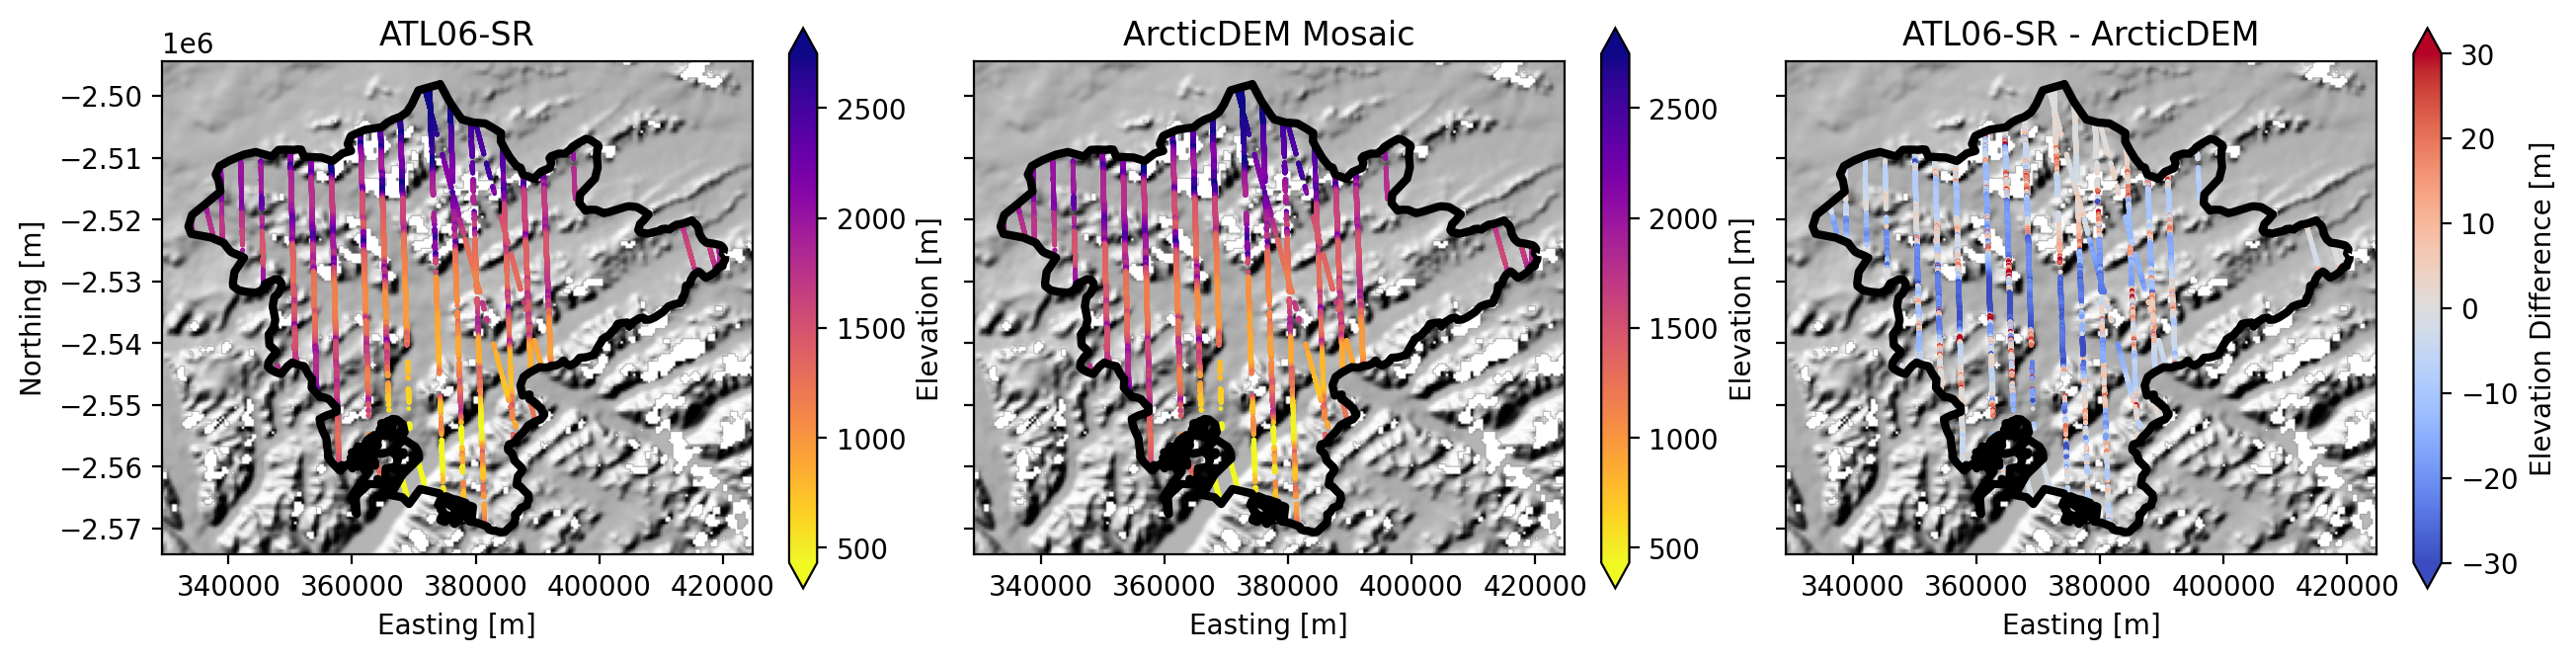

In [19]:
# create polar stereographic plot of ATL06-SR data
# EPSG codes are a simple way to define many coordinate reference systems
crs = 'EPSG:3413'
# create figure axis
fig,ax1 = plt.subplots(num=1, ncols=3, sharex=True, sharey=True, figsize=(13,3.5))
ax1[0].set_aspect('equal', adjustable='box')

# calculate normalization for height plots
vmin, vmax = gdf2['h_mean'].quantile((0.02, 0.98)).values

# calculate difference between sliderule and ArcticDEM mosaic heights
gdf2['difference'] = gdf2['h_mean'] - gdf2['mosaic.mean']
filtered = gdf2[gdf2['difference'].abs() < 100].to_crs(crs)

# plot ATL06-SR elevation
ax1[0].set_title('ATL06-SR')
label = f'Elevation [m]'
sc = filtered.plot(ax=ax1[0], zorder=1, markersize=0.5,
    column='h_mean', cmap='plasma_r', vmin=vmin, vmax=vmax,
    legend=True, legend_kwds=dict(label=label, shrink=0.90, extend='both'))
sc.set_rasterized(True)

# plot ArcticDEM mosaic elevation
ax1[1].set_title('ArcticDEM Mosaic')
label = f'Elevation [m]'
sc = filtered.plot(ax=ax1[1], zorder=1, markersize=0.5,
    column='mosaic.mean', cmap='plasma_r', vmin=vmin, vmax=vmax,
    legend=True, legend_kwds=dict(label=label, shrink=0.90, extend='both'))
sc.set_rasterized(True)

# plot difference between heights
ax1[2].set_title('ATL06-SR - ArcticDEM')
label = f'Elevation Difference [m]'
sc = filtered.plot(ax=ax1[2], zorder=1, markersize=0.5,
    column='difference', cmap='coolwarm', vmin=-30, vmax=30,
    legend=True, legend_kwds=dict(label=label, shrink=0.90, extend='both'))
sc.set_rasterized(True)

# convert regions into a geoseries object
regions = []
for poly in m2.regions:
    lon,lat = sliderule.io.from_region(poly)
    regions.append(shapely.geometry.Polygon(zip(lon,lat)))
gs = gpd.GeoSeries(regions, crs='EPSG:4326').to_crs(crs)

# add background and labels
for ax in ax1:
    # plot each region of interest
    gs.plot(ax=ax, facecolor='none', edgecolor='black', lw=3)
    # plot ArcticDEM as basemap
    plot_arcticdem(ax, srs=crs)
    # add x label
    ax.set_xlabel('{0} [{1}]'.format('Easting','m'))
# add y label
ax1[0].set_ylabel('{0} [{1}]'.format('Northing','m'))

# adjust subplot and show
fig.subplots_adjust(left=0.06, right=0.98, bottom=0.08, top=0.98, wspace=0.1)

```{tip}
Compared with the ArcticDEM mosaic, ICESat-2 is showing much lower elevations for large parts of this glacier. Any ideas on why?
```

### Advanced ICESat-2 SlideRule Example: PhoREAL Vegetation Metrics

For this example, we will also use SlideRule to produce canopy metrics using the ATL08 PhoREAL API. The name comes from the University of Texas team that developed PhoREAL and collaborated with us to get their algorithms into SlideRule. The PhoREAL functionality within SlideRule uses the land surface classifications for each photon provided by the [ICESat-2 Land and Vegetation Height Product (ATL08)](https://nsidc.org/data/atl08). Similar to the SlideRule elevation functionality, these metrics can be calculated at different lengths scales and with different options for classification. The set of parameters specific to the ATL08 processing are provided under the `phoreal` key.

Documentation for this functionality can be found in the [API reference](https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl08p).  

In [20]:
# create ipyleaflet map in specified projection
m3 = sliderule.ipysliderule.leaflet('Global', zoom=10,
    full_screen_control=True)
# add ESRI imagery layer
m3.add_layer(layers=['ESRI imagery'])
# read and add region of interest
reg = gpd.read_file('grandmesa.geojson')
m3.add_region(sliderule.io.from_geodataframe(reg))
m3.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

#### Set options for making PhoREAL science data processing requests to SlideRule

Here, we'll be able to adjust all the potential parameters for making a SlideRule ICESat-2 `atl08` request.

<table>
  <tbody>
    <tr>
      <th align='center' max-width="25%">Parameter</th>
      <th align='left' max-width="75%">Definition</th>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Classification
       </td>
      <td align='left' valign='top' width="75%">
        Photon classification types to use in signal selection
        <ul style="line-height: 1.5em">
            <li>atl03: signal confidence</li>
            <li>quality: signal quality flag</li>
            <li>atl08: classification from the land and vegetation algorithm</li>
            <li>yapc: confidence determined using a clustering algorithm</li>
        </ul>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Land class
       </td>
      <td align='left' valign='top' width="75%">
        ATL08 land and vegetation classification
        <ol start="0" style="line-height: 1.5em">
            <li>photon is noise or background</li>
            <li>photon is ground</li>
            <li>photon is canopy</li>
            <li>photon is top of canopy</li>
            <li>photon is not classified</li>
        </ol>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PhoREAL Bin Size
       </td>
      <td align='left' valign='top' width="75%">
        Size of the vertical histogram bin in meters
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PhoREAL Geolocation
       </td>
      <td align='left' valign='top' width="75%">
        Method for calculating segment geolocation variables
        <ul start="0" style="line-height: 1.5em">
            <li>mean: average value across all photons in the segment</li>
            <li>median: median value across all photons in the segment</li>
            <li>center: center of first and last photons in the segment</li>
        </ul>
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PhoREAL Use abs h
       </td>
      <td align='left' valign='top' width="75%">
        Use absolute photon event elevations rather than normalized heights
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PhoREAL ABoVE
       </td>
      <td align='left' valign='top' width="75%">
        Use the ABoVE photon classifier
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        PhoREAL Waveform
       </td>
      <td align='left' valign='top' width="75%">
        Return the photon height histograms
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Length
       </td>
      <td align='left' valign='top' width="75%">
        How long each segment should be in meters
       </td>
    </tr>
    <tr>
      <td align='left' valign='top' width="25%">
        Step
       </td>
      <td align='left' valign='top' width="75%">
        Distance between successive segments in meters
       </td>
    </tr>
  </tbody>
</table>

In [21]:
# display widgets for setting SlideRule parameters
SRwidgets.set_atl08_defaults()
SRwidgets.VBox(SRwidgets.atl08())

In [22]:
%%time
# build sliderule parameters using latest values from widget
parms = SRwidgets.build_atl08()
# reduce data to a single cycle
parms["cycle"] = 16

# clear existing geodataframe results
elevations = [sliderule.emptyframe()]

# for each region of interest
for poly in m3.regions:
    # add polygon from map to sliderule parameters
    parms["poly"] = poly
    # make the request to the SlideRule (ATL08-SR) endpoint
    # and pass it the request parameters to request ATL08 vegetation metrics
    elevations.append(sliderule.icesat2.atl08p(parms, keep_id=True))
# concatenate the results into a single geodataframe
gdf3 = gpd.pd.concat(elevations)

CPU times: user 1.06 s, sys: 23.5 ms, total: 1.09 s
Wall time: 12.7 s


#### Review GeoDataFrame output
There are different columns for the `atl08` request, which add the vegetation metrics. Here, we will inspect the top of the ATL08 GeoDataFrame using `head()`.

See the [SlideRule ICESat-2 Vegetation Metrics documentation](https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html#vegetation-metrics-atl08) for descriptions of each column

In [23]:
print(f'Returned {gdf3.shape[0]} records')
gdf3.head()

Returned 27492 records


,geometry,cycle,h_mean_canopy,rgt,gt,landcover,canopy_openness,h_te_median,gnd_ph_count,x_atc,...,snowcover,solar_elevation,veg_ph_count,h_max_canopy,canopy_h_metrics,spot,ph_count,h_min_canopy,segment_id,h_canopy
2022-07-05 17:55:20.565275648,POINT (-107.77143 39.14705),16.0,13.092090,211.0,50.0,111.0,8.008397,3092.035645,2.0,2.833825e+12,...,1.0,66.309395,15.0,23.778809,"(0.784912109375, 0.784912109375, 0.78491210937...",2.0,17.0,0.542725,784595.0,23.778809
2022-07-05 17:55:20.567925760,POINT (-107.77145 39.14689),16.0,12.478679,211.0,50.0,111.0,8.395076,0.000000,0.0,2.833825e+12,...,1.0,66.309395,9.0,22.807617,"(0.784912109375, 0.784912109375, 0.78491210937...",2.0,9.0,0.542725,784596.0,22.807617
2022-07-05 17:55:20.570825728,POINT (-107.77147 39.14670),16.0,12.215991,211.0,50.0,111.0,9.614838,3090.658447,1.0,2.833857e+12,...,1.0,66.309509,20.0,25.861328,"(2.033203125, 2.033203125, 2.033203125, 2.0332...",2.0,21.0,1.491211,784597.0,25.861328
2022-07-05 17:55:20.572175872,POINT (-107.77148 39.14661),16.0,13.466128,211.0,50.0,111.0,9.000566,3090.658447,1.0,2.833884e+12,...,1.0,66.309608,23.0,25.861328,"(2.033203125, 2.033203125, 2.73828125, 2.73828...",2.0,24.0,1.491211,784597.0,25.861328
2022-07-05 17:55:20.573575680,POINT (-107.77149 39.14653),16.0,16.001398,211.0,50.0,111.0,5.272099,0.000000,0.0,2.833884e+12,...,1.0,66.309608,11.0,23.672363,"(7.568359375, 7.568359375, 7.568359375, 10.362...",2.0,11.0,7.016846,784598.0,23.672363


#### Add Vegetation Metrics GeoDataFrame to map

Here, we're going to visualize the canopy height `h_canopy`. This is the 98<sup>th</sup> percentile of the histogram of canopy photons that are located above the Earth's surface.

In [24]:
SRwidgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [25]:
# ATL06-SR fields for hover tooltip
fields = m3.default_atl08_fields()
gdf3.leaflet.GeoData(m3.map, column_name=SRwidgets.column_name, cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, tooltip_width='280px', colorbar=True,
    fields=fields)
# install handlers and callbacks
gdf3.leaflet.add_selected_callback(SRwidgets.atl06_click_handler)
m3.add_region_callback(gdf3.leaflet.handle_region)

```{tip}
How does the canopy height compare with the visual imagery at Grand Mesa? 
```

### Advanced ICESat-2 SlideRule Example: Subsetting ATL03 photon cloud data

SlideRule can also be used to subset ATL03 geolocated photon height products, which are returned as a geopandas GeoDataFrame at the photon rate.  Documentation for this function can be found in the [API reference](https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl03sp).

Because each granule contains so many photons, it is good practice to subset the data as much as possible by limiting the subsetting area and the number of granules to be processed. Here, we supply a GeoJSON file of Fenris Glacier for trimming the photon data. We also supply a reference ground track and cycle number to reduce the number of granules to be processed to a single file. Finally, we specify that only tracks `GT1L` and `GT1R` within the granule should be subset. This will still return hundreds of thousands of photons for the region!

The other parameters in the request are used to specify different aspects of the ATL03 subsetting request.  The surface type for photon classification (`srt`) in this case is _land ice_. This surface type parameter is used in conjunction the photon confidence level `cnf` parameter. Here, we are requesting that all classified photons for the surface type are returned.

In [26]:
# read Region of Interest
reg = gpd.read_file('Fenris_Gletscher_PS_v1.4.2.geojson')
region = sliderule.io.from_geodataframe(reg)
RGT = 71
cycle = 19
# only process data for GT1L and GT1R
PT = 1

# Build ATL03 Subsetting Request Parameters
parms = {
    "poly": region[0],
    "rgt": RGT,
    "cycle": cycle,
    "track": PT,
    "srt": sliderule.icesat2.SRT_LAND_ICE,
    "cnf": sliderule.icesat2.CNF_BACKGROUND,
    "len": 20.0,
    "pass_invalid": True
}

# Make ATL03 Subsetting Request
atl03 = sliderule.icesat2.atl03sp(parms)

HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 457 points using tolerance of 0.0001
HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 375 points using tolerance of 0.001
HTTP Request Error: Request Entity Too Large
Using simplified polygon (for CMR request only!), 73 points using tolerance of 0.01


#### Review GeoDataFrame output
The ATL03 GeoDataFrame will have variables at the photon rate. Here, we will inspect the columns and variables at the top of the ATL03 GeoDataFrame using `head()`. See the [SlideRule ICESat-2 Geolocated Photon documentation](https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html#segmented-photon-data-atl03) for descriptions of each column

In [27]:
print(f'Returned {atl03.shape[0]} records')
atl03.head()

Returned 311014 records


,background_rate,segment_dist,pair,segment_id,rgt,solar_elevation,sc_orient,track,cycle,quality_ph,...,landcover,relief,atl08_class,height,yapc_score,snowcover,y_atc,x_atc,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2023-03-26 00:46:52.890679296,12313.95134,1.261795e+07,0,629952,71,-18.709667,0,1,19,0,...,255,0.0,4,2572.278076,0,255,3279.790527,-9.537612,POINT (-36.15309 66.83899),1
2023-03-26 00:46:52.890679296,12313.95134,1.261795e+07,0,629952,71,-18.709667,0,1,19,0,...,255,0.0,4,2573.593262,0,255,3279.780273,-9.541133,POINT (-36.15309 66.83899),1
2023-03-26 00:46:52.890679296,12313.95134,1.261795e+07,0,629952,71,-18.709667,0,1,19,0,...,255,0.0,4,2576.837158,0,255,3279.754639,-9.549738,POINT (-36.15309 66.83899),1
2023-03-26 00:46:52.890679296,12313.95134,1.261795e+07,0,629952,71,-18.709667,0,1,19,0,...,255,0.0,4,2576.950439,0,255,3279.753906,-9.549738,POINT (-36.15309 66.83899),1
2023-03-26 00:46:52.890679296,12313.95134,1.261795e+07,0,629952,71,-18.709667,0,1,19,0,...,255,0.0,4,2572.457275,0,255,3279.789062,-9.538003,POINT (-36.15309 66.83899),1


#### Create plot for a single track of photon heights
Here, we're going to use the same SlideRule ICESat-2 transect plot functionality as prior, but for visualizing the geolocated photons.

- `scatter`: Will plot ATL03 data returned by SlideRule for a single RGT, ground track and cycle

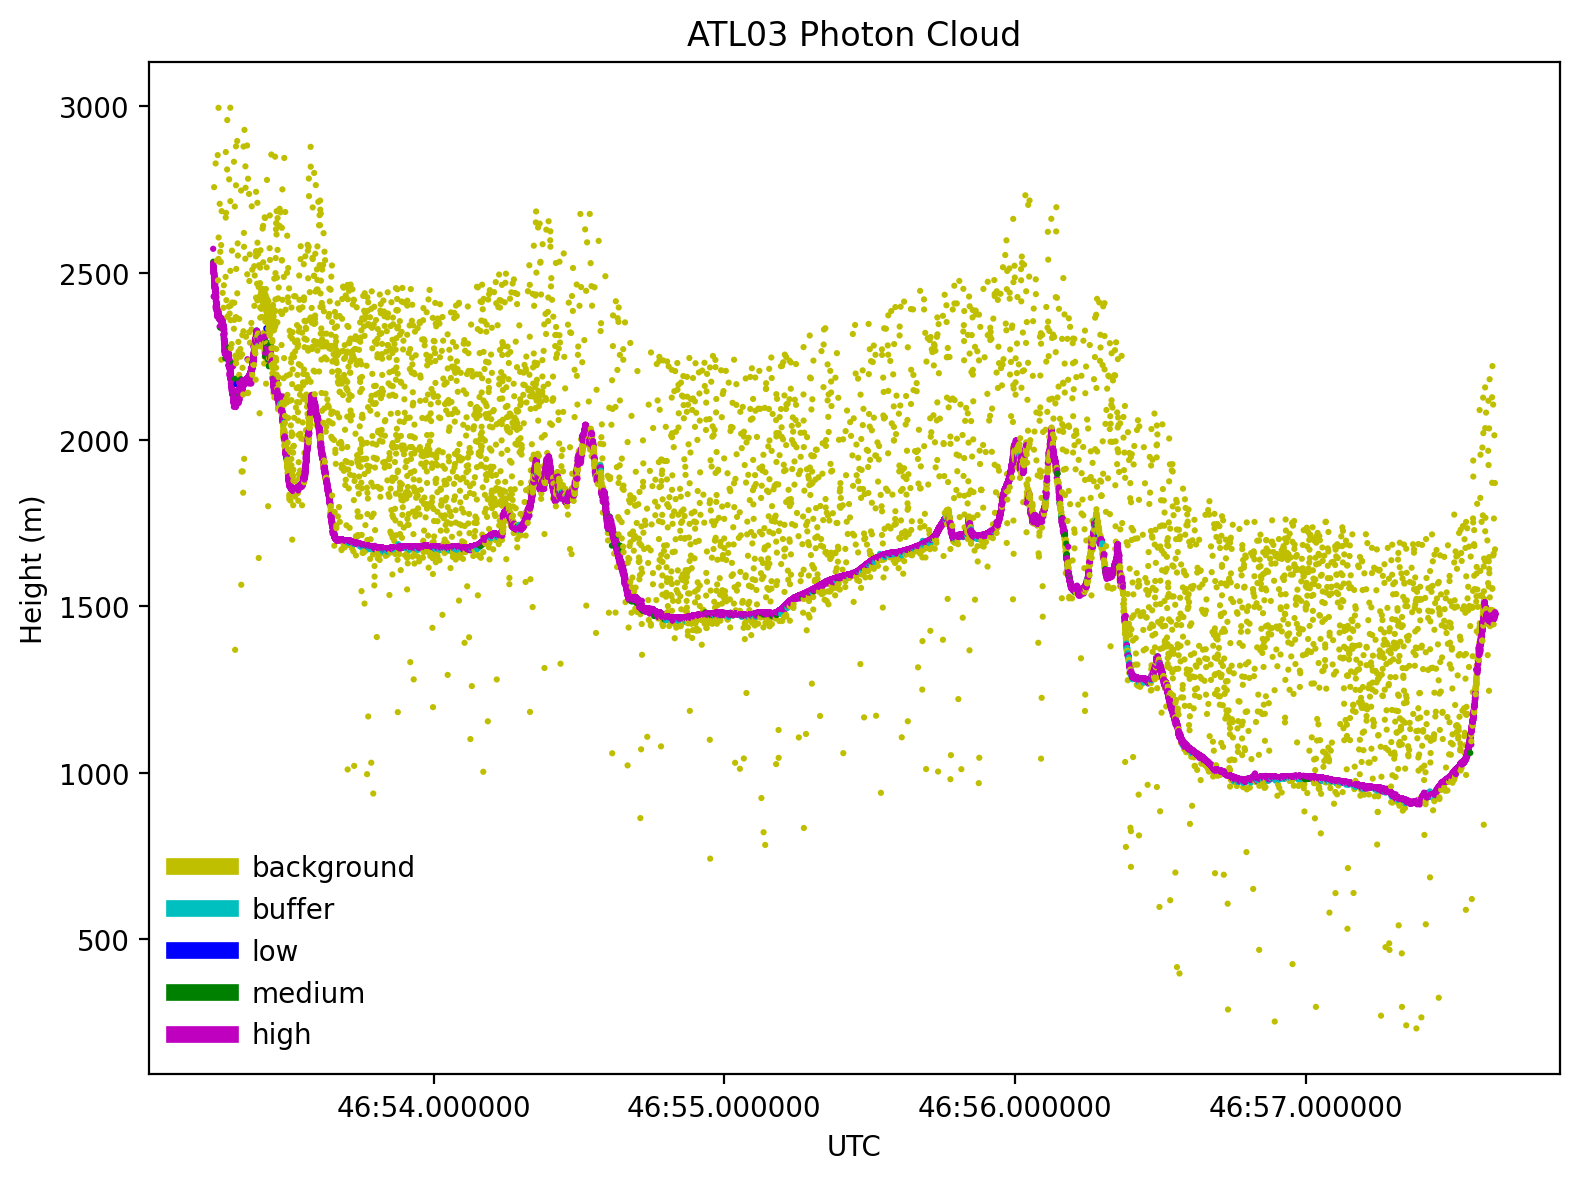

In [28]:
atl03.icesat2.plot(atl03='dataframe', kind='scatter', title='ATL03 Photon Cloud',
    legend=True, legend_frameon=True,
    classification='atl03', segments=False,
    RGT=RGT, cycle=cycle, GT=sliderule.icesat2.GT1R)

```{tip}
A lot of these photon events are "background" photons, meaning that they are likely emitted from the sun and not from ICESat-2.
```

### Direct File Read Example

SlideRule also can directly read data from HDF5 files stored in s3 using `h5coro`, a cloud-optimized HDF5 reader built by the SlideRule team. In the example below, data from the first 25 segments are read from an ATL06 granule.  The results are returned in a dictionary of arrays, where each key is the name of the dataset.  The entirety of a dataset can be read by setting the number of rows to `h5.ALL_ROWS`. 

In [29]:
resource = 'ATL06_20181017222812_02950102_006_02.h5'
beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
variables = ['latitude', 'longitude']
startrow, numrows = (0, 25)
datasets = [dict(dataset=f'/{b}/land_ice_segments/{v}', startrow=startrow, numrows=numrows)
    for b in beams for v in variables]
atl06 = sliderule.h5.h5p(datasets, resource, 'icesat2')

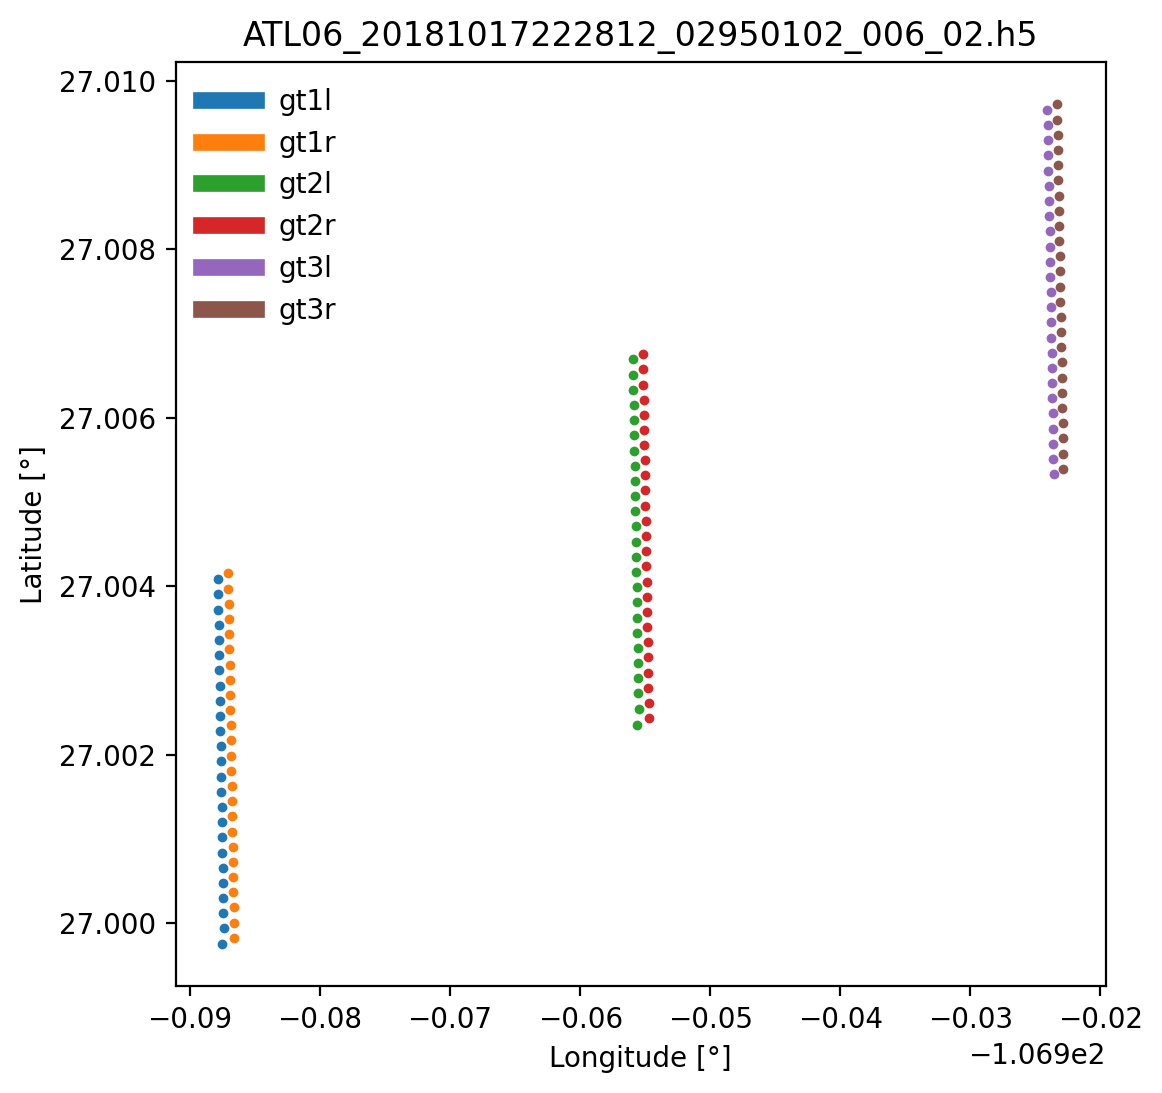

In [30]:
fig, ax2 = plt.subplots(num=2, figsize=(6,6))
for b in beams:
    ax2.plot(atl06[f'/{b}/land_ice_segments/longitude'],
        atl06[f'/{b}/land_ice_segments/latitude'],
        '.-', ms=5, lw=0, label=b)
ax2.set_title(resource)
ax2.set_xlabel('Longitude [\u00B0]')
ax2.set_ylabel('Latitude [\u00B0]')
lgd = ax2.legend(frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)

### Private Clusters

The SlideRule project supports the deployment of private clusters.  A private cluster is a separate deployment of the public SlideRule service with the only difference being it requires authenticated access.  These clusters are managed through the [**SlideRule Provisioning System**](https://ps.slideruleearth.io) and require both an account on that system along with an association with a funding organization.  For more information on private clusters, please see the [users guide](https://slideruleearth.io/web/rtd/user_guide/Private-Clusters.html).

The public SlideRule service is provisioned the exact same way as a private cluster and is managed by the SlideRule Provisioning System. Each cluster has its own subdomain and configuration. For the public cluster, the configuration specifies that no authentication is needed, and the subdomain is "sliderule", so access to the public cluster is at https://sliderule.slideruleearth.io.  For the other clusters, access requires authentication and the subdomain is the set to the name of the organization funding the cluster.  For example, the University of Washington private cluster is at https://uw.slideruleearth.io.

### Summary 

<table>
  <tbody>
    <tr>
      <td align='center' width="10%">
        <img src="https://slideruleearth.io/web/assets/images/SlideRule-whiteBelly.png">
      </td>
      <td align='left' max-width="90%">
        SlideRule is a cost-effective <i>science data as a service</i> solution that provides responsive results to users. SlideRule can enable large scale access to the NASA and other Earth science data and provide science-quality algorithms in an open and documented way. The SlideRule team strives to provide simple, well-documented APIs that are easy to install and use, as well as a web client for online demonstration. Improvements and fixes can be made quickly to limit downtime and enable new functionality. The SlideRule system is highly scalable to meet the processing demand at any given time. In addition, private clusters can be made available to users for large-scale requests. See more at <a href="https://slideruleearth.io">slideruleearth.io</a>.
      </td>
    </tr>
  </tbody>
</table>